# **TR-2023/05 - Technical report: K-Means, Campinas, Brazil Groundwater Hydrochemical Dataset 2019**

|Technical Report ID  |2022/11|
|--|--|
| Title |Construction of Study Dataset|
| Authors | Diego Xavier Machado, Paula Dornhofer, Ana Elisa Abreu|
| Creation Date| 2023 - 05|


# Descrição Geral
Esse notebook tem como objetivo dividir a base de dados das coletas feitas pelo Instituto de Geociências da Unicamp (IG) com base na data em que as coletas foram feitas e aplicar o algoritmo *K-Means* para obter grupos de poços relativamente semelhantes com base nos dados fornecidos, fornecendo também um mapeamento espacial de acordo com os rótulos obtidos após o agrupamento. Para isso, é necessário que a base de dados das coletas esteja tratada previamente.


In [ ]:
#-----------------------------------------------------#
#              IMPORTAÇÃO DAS BIBIOTECAS              #
#-----------------------------------------------------#

!pip install kneed
!pip install pyproj
!pip install folium
!pip install git+https://github.com/IanAguiar-ai/metrics.git

from pyproj import Proj
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from random import seed, random
from mutual_information import metrics as mtr

  Cloning https://github.com/IanAguiar-ai/metrics.git to /tmp/pip-req-build-zxcx9tg6
  Running command git clone --filter=blob:none --quiet https://github.com/IanAguiar-ai/metrics.git /tmp/pip-req-build-zxcx9tg6
  Resolved https://github.com/IanAguiar-ai/metrics.git to commit 452d14433fbfdb08a40602b9f8512873c129157e
  Preparing metadata (setup.py) ... done
  Created wheel for metrics: filename=metrics-0.0.12-py3-none-any.whl size=17647 sha256=a407846abc224ad0f8a102b53be80e921fd11433da17f6ee26e29d89006cfc7a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqsa023x/wheels/c7/48/53/4f50b27b511fdefedb30381ad08615e2dc2bae6ab5a0986841
Successfully built metrics


# Importação dos arquivos
Para esse notebook, será necessário apenas o arquivo da base de dados das coletas, de forma já tratada, em arquivo `.csv`.

In [ ]:
#-----------------------------------------------------#
#               IMPORTAÇÃO DOS ARQUIVOS               #
#-----------------------------------------------------#

from google.colab import drive
drive.mount('/content/drive')

# df = Base de dados
df = pd.read_csv('/content/drive/Shareddrives/datasci4water/IG/data/interim/df_final.csv')
df = df.reset_index(drop=True)

Mounted at /content/drive


# Separação da base de dados principal de acordo com a data:
Com a base de dados principal, será criado duas outras novas base de dados. Uma para cada período de coleta. Portanto a data é a variável responsável por essa divisão. Assim, formam-se, bases de dados para os seguintes períodos:


*   Abril de 2019
*   Outubro de 2019



In [ ]:
#-----------------------------------------------------#
#         SEPARAÇÃO DA BASE DE DADOS POR DATA         #
#-----------------------------------------------------#

# Fazer a separação por data
df_abril = df.loc[df['date'] == '2019/04']
df_outubro = df.loc[df['date'] == '2019/10']


# Padronização dos valores
Como a base de dados possuem valores não numéricos referentes ao poço da amostra (coluna "*well*") e referente a data da coleta (coluna "*date*"), faremos a separação apenas dos valores numéricos para que o trabalho do algoritmo de aprendizado de máquina seja apenas sobre esses valores numéricos.

Ademais, como os valores possuem uma grande diferença entre ordens de grandeza, será feito a padronização desses valores, mantendo-os na mesma escala. Dessa  forma, pode-se evitar que variáveis com altas ordens de grandeza implique no cálculo de grandes distâncias entre os dados e influencie negativamente o funcionamento do algoritmo *K-Means*.

In [ ]:
#-----------------------------------------------------#
#               PADRONIZAÇÃO DOS VALORES              #
#-----------------------------------------------------#

#  Separação dos valores numéricos
df_abril_values = df_abril.iloc[:, 2:df_abril.shape[1]]
df_outubro_values = df_outubro.iloc[:, 2:df_outubro.shape[1]]

# Padronização dos vallores propriamente dito
df_scaler = StandardScaler()
df_abril_values = df_scaler.fit_transform(df_abril_values)
df_outubro_values = df_scaler.fit_transform(df_outubro_values)

# Mudança no sistema de coordenadas
As coordenadas no Dataframe estão no sistema UTM. Para a utilização da biblioteca *folium* no qual serão impressos os rótulos do agrupamento, as coordenadas devem estar no sistema de graus decimais. Para isso, faz-se a conversão dos valores


In [ ]:
#-----------------------------------------------------#
#                MUDANÇA DE COORDENADAS               #
#-----------------------------------------------------#

def utm_para_graus_decimais(easting, northing, lista_coordenadas):
    zona = 23
    hemisferio = 'S'
    proj = Proj(proj='utm', zone=zona, south=True, ellps='WGS84')
    longitude, latitude = proj(easting, northing, inverse=True)
    lista_coordenadas.append([latitude, longitude])


coordenadas_abril = []
coordenadas_outubro = []

for i in range(df_abril.shape[0]):
  utm_n = df_abril.iloc[i, 48]
  utm_e = df_abril.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_abril)

for i in range(df_outubro.shape[0]):
  utm_n = df_outubro.iloc[i, 48]
  utm_e = df_outubro.iloc[i, 47]
  utm_para_graus_decimais(utm_e, utm_n, coordenadas_outubro)

# Métricas para o agrupamento do algoritmo K-Means
Antes de executarmos as métricas, foi necessário resolver corrigir o seguinte problema:

  *Devido ao baixo número de amostras e ao grande número de variáveis na base de dados, cada vez em que se executava o algoritmo K-Means era possível fazer os grupos diferentes do experimento anterior.*

  Para contornar esse problema, para cada número K de grupos do algoritmo K-Means, são feitos vários experimentos e o agrupamento mais frequente é considerado o melhor agrupamento para aquuele número de grupos. Dessa forma, fa-se uso da seguinte função.

In [ ]:
def melhor_agrupamento(dados, n_grupos, n_execucoes):
  resultados = []
  for _ in range(n_execucoes):
    kmeans = KMeans(n_clusters=n_grupos, n_init=10)
    kmeans.fit(dados)
    resultados.append(kmeans.labels_)
  # Contar a frequência de cada conjunto de grupos
  frequencias = {}
  for grupos in resultados:
      grupos_str = ' '.join(map(str, grupos))
      if grupos_str in frequencias:
          frequencias[grupos_str] += 1
      else:
          frequencias[grupos_str] = 1
  # Encontrar os grupos mais frequentes
  grupos_mais_frequentes = max(frequencias, key=frequencias.get)
  grupos_mais_frequentes = list(map(int, grupos_mais_frequentes.split()))
  return grupos_mais_frequentes

## Métricas de Abril

In [ ]:
clusters_list_abril = []
for k in range(2, 7):
  clusters_list_abril.append(melhor_agrupamento(df_abril_values, k, 20000))
clusters_list_abril = np.array(clusters_list_abril)

In [ ]:
np.save('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/kmeans_clusters_list_abril_com_coord.npy', clusters_list_abril)

In [ ]:
clusters_list_abril = np.load('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/kmeans_clusters_list_abril_com_coord.npy')

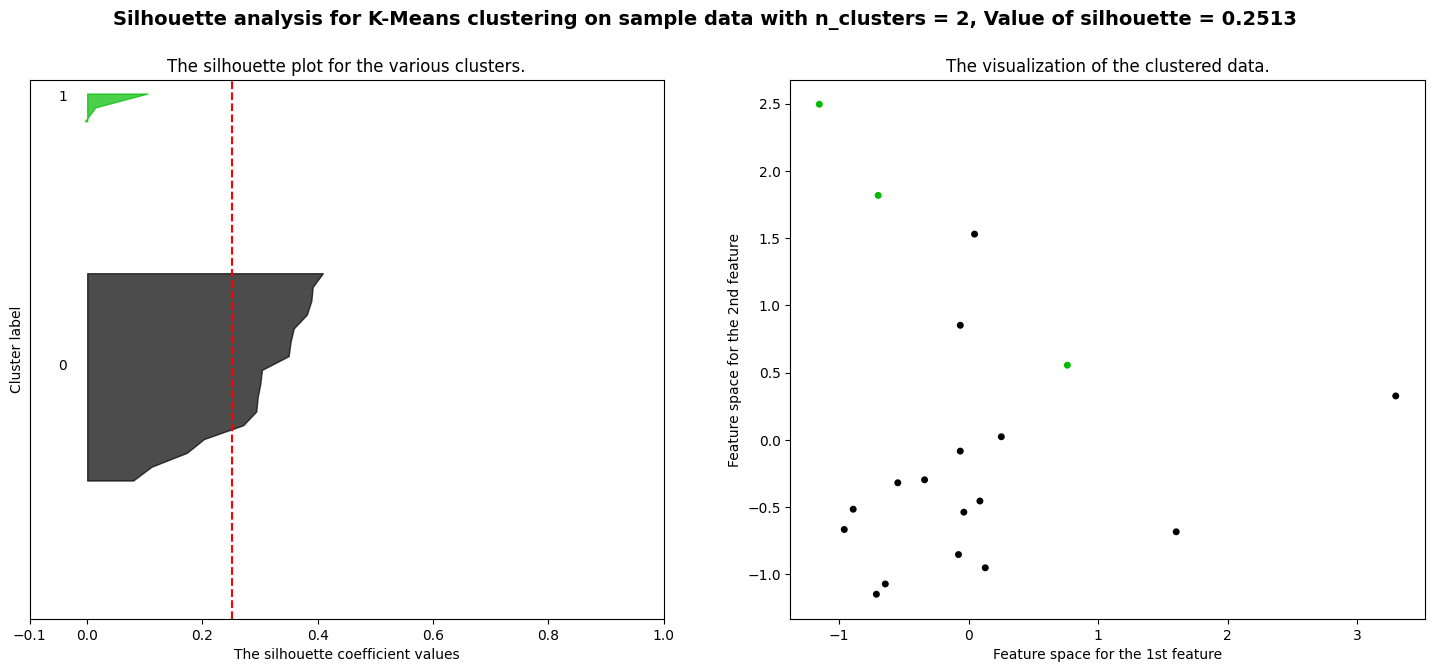

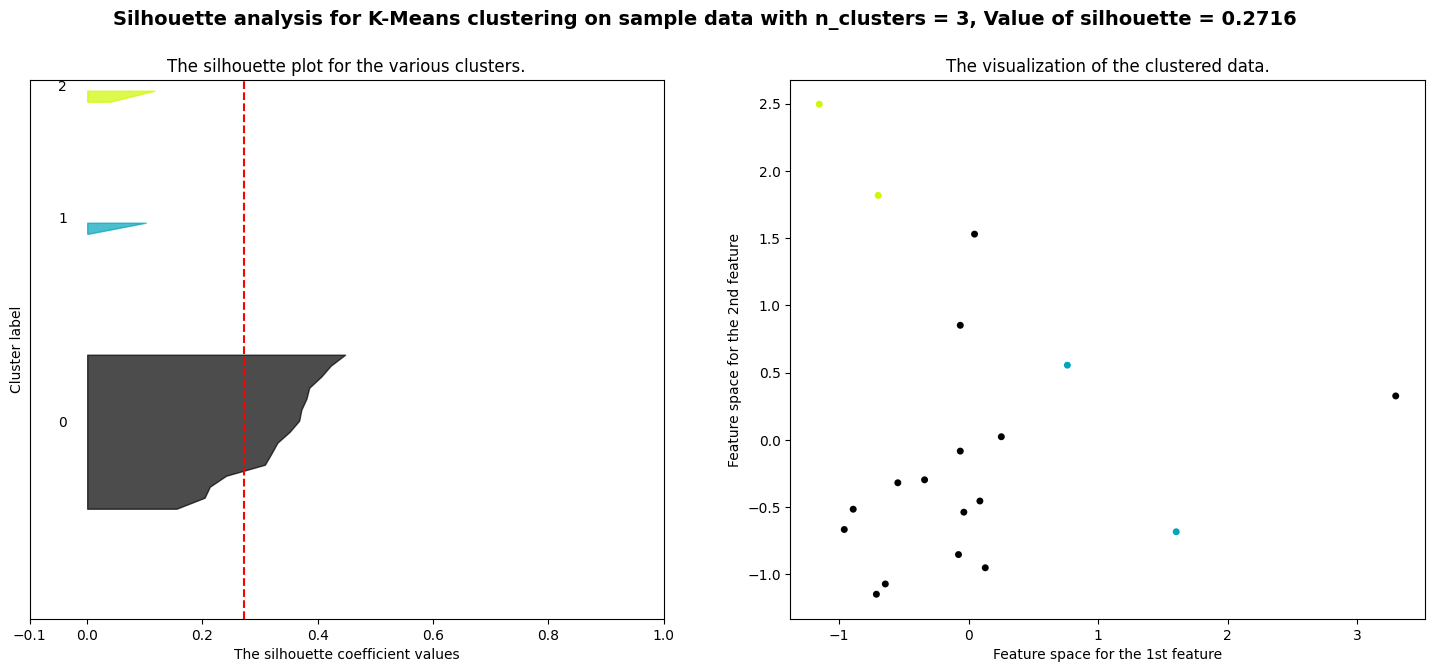

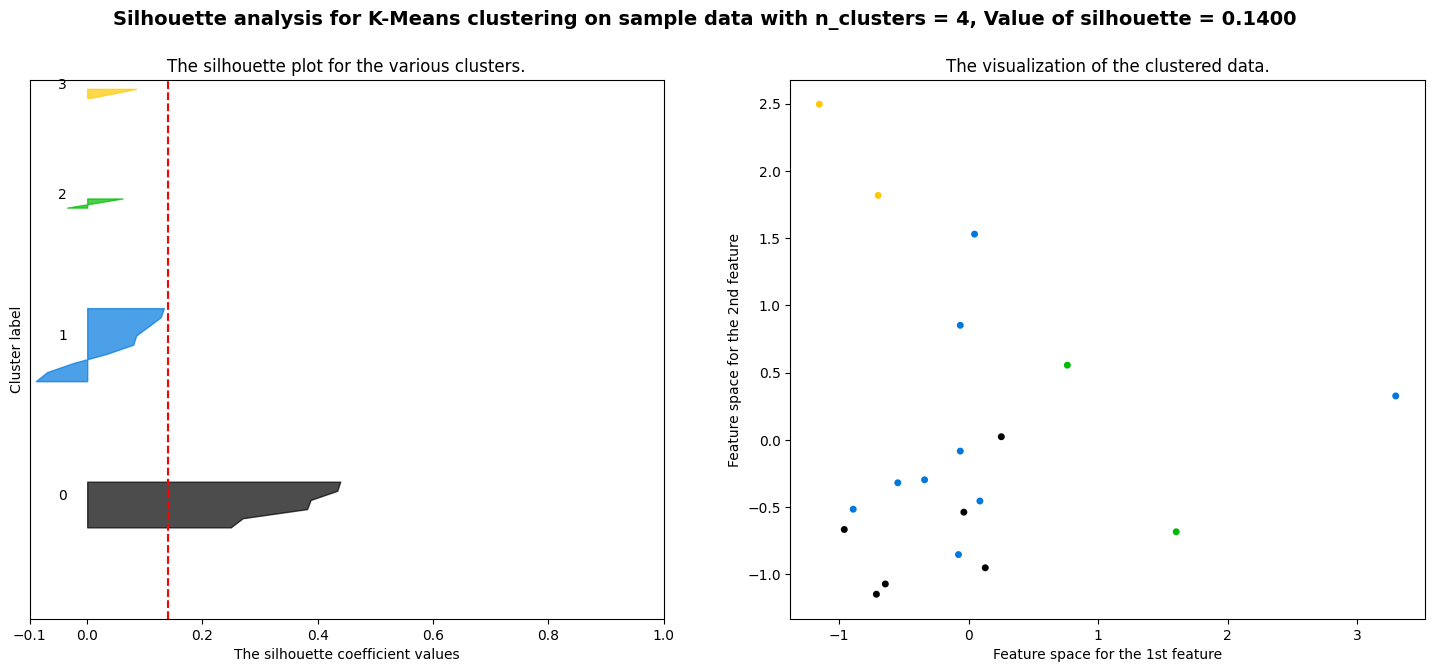

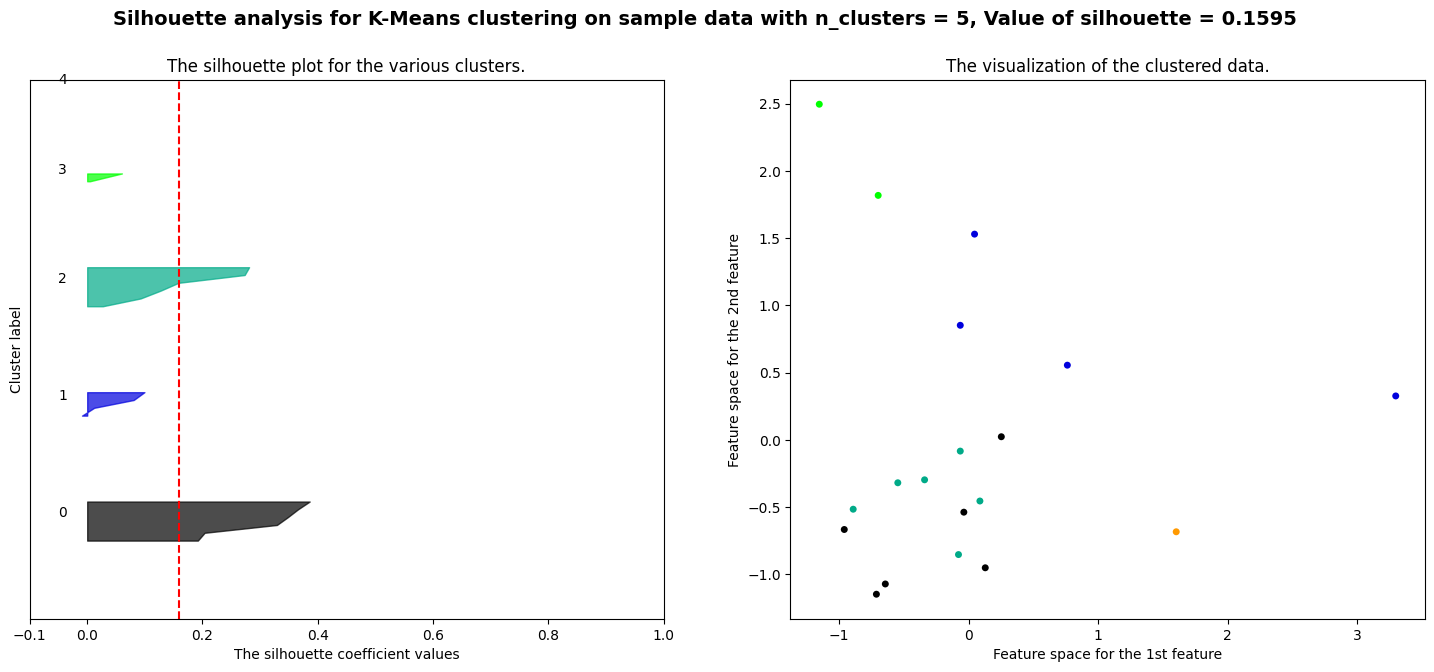

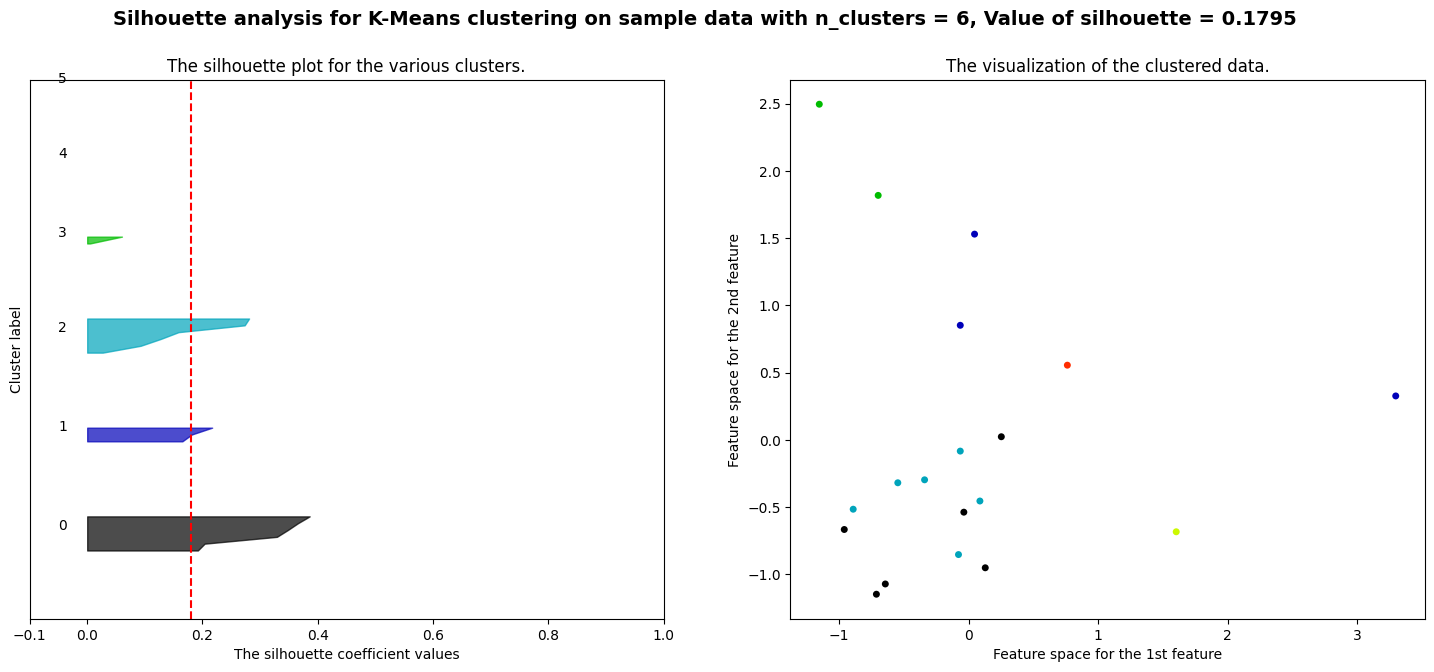

{'Number of\nClusters': dict_keys([2, 3, 4, 5, 6]),
 'Silhouette\nAnalysis': ['0.251*', '0.271**', '0.140', '0.159', '0.179'],
 'Calinski\nHarabasz': ['3.726', '3.975', '4.270', '4.618*', '4.988**'],
 'Davies\nBoulding': ['1.559', '1.196', '1.379', '1.187', '0.962**']}

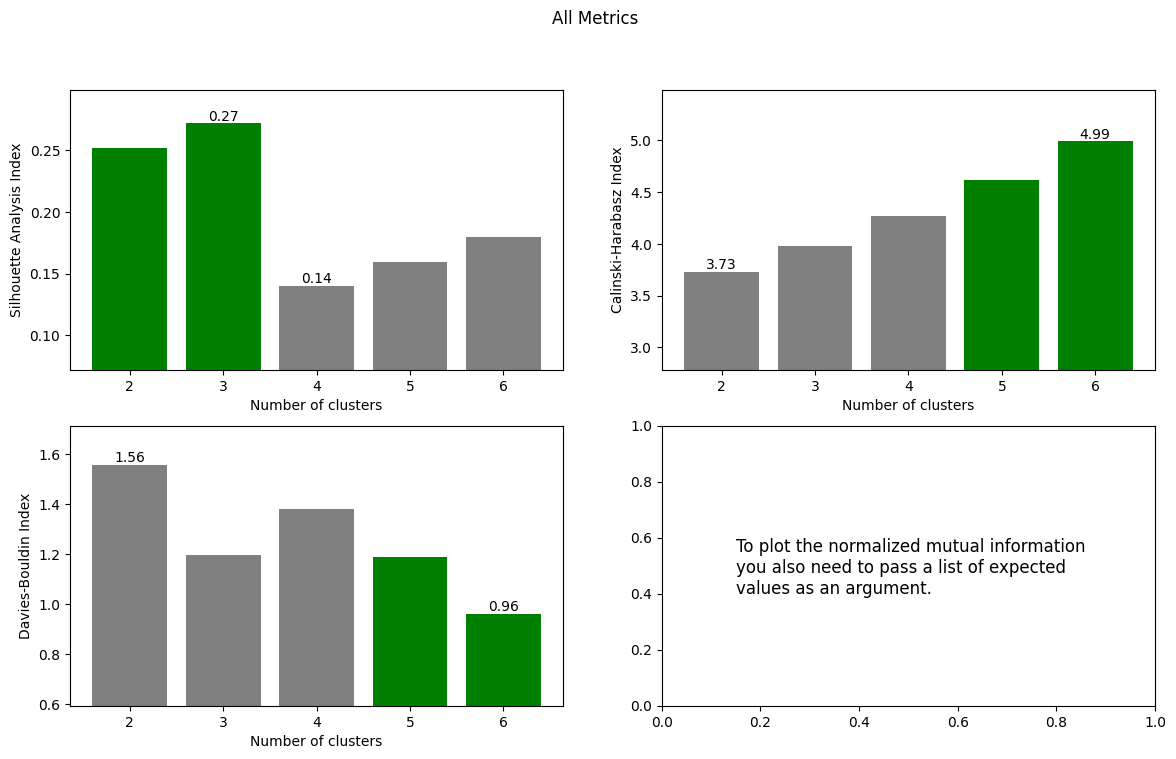

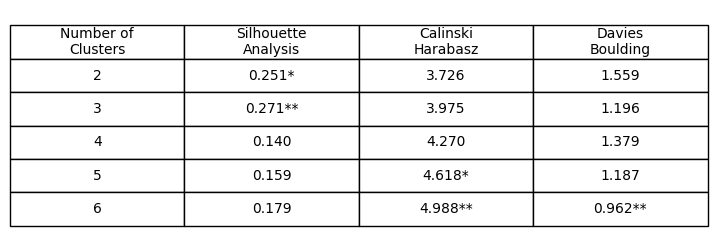

In [ ]:
mtr.print_metrics(clusters_list_abril, df_abril_values)

## Métricas de Outubro

In [ ]:
clusters_list_outubro = []
for k in range(2, 7):
  clusters_list_outubro.append(melhor_agrupamento(df_outubro_values, k, 20000))
clusters_list_outubro = np.array(clusters_list_outubro)

In [ ]:
np.save('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/kmeans_clusters_list_outubro_com_coord.npy', clusters_list_outubro)

In [ ]:
clusters_list_outubro = np.load('/content/drive/Shareddrives/datasci4water/IG/data/interim/clusters/kmeans_clusters_list_outubro_com_coord.npy')

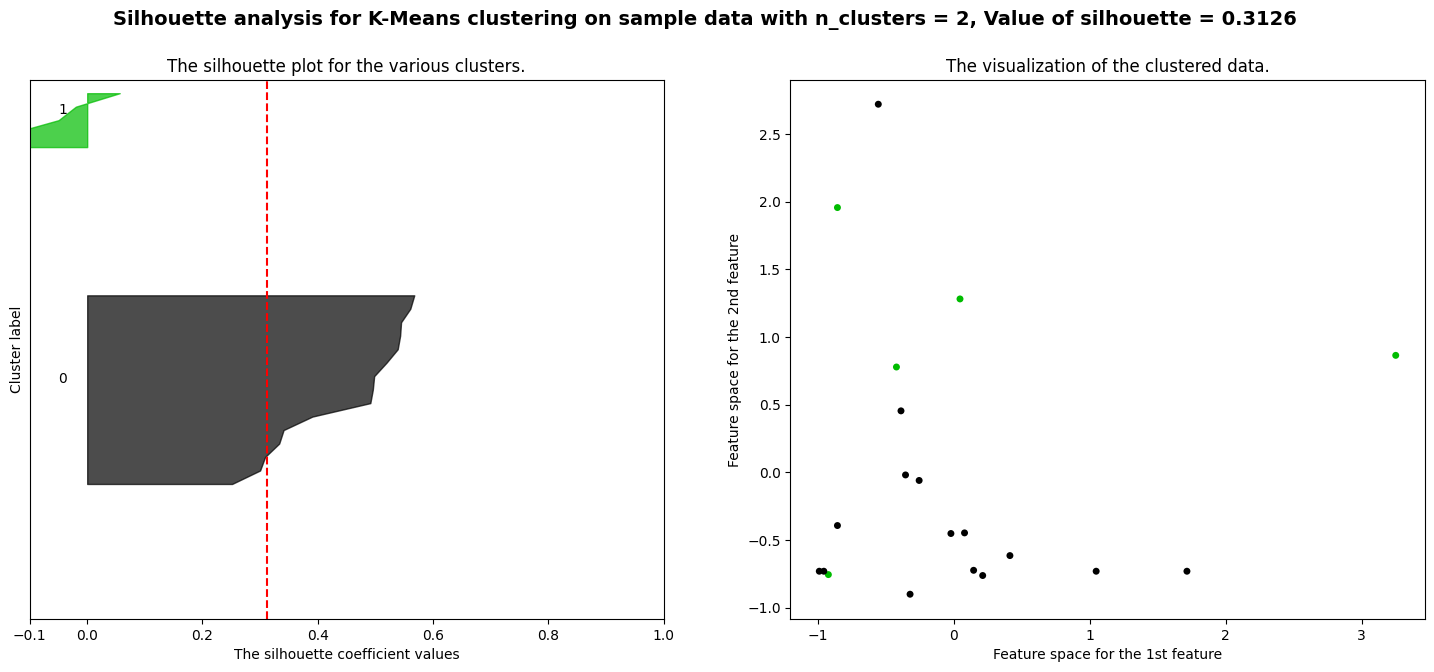

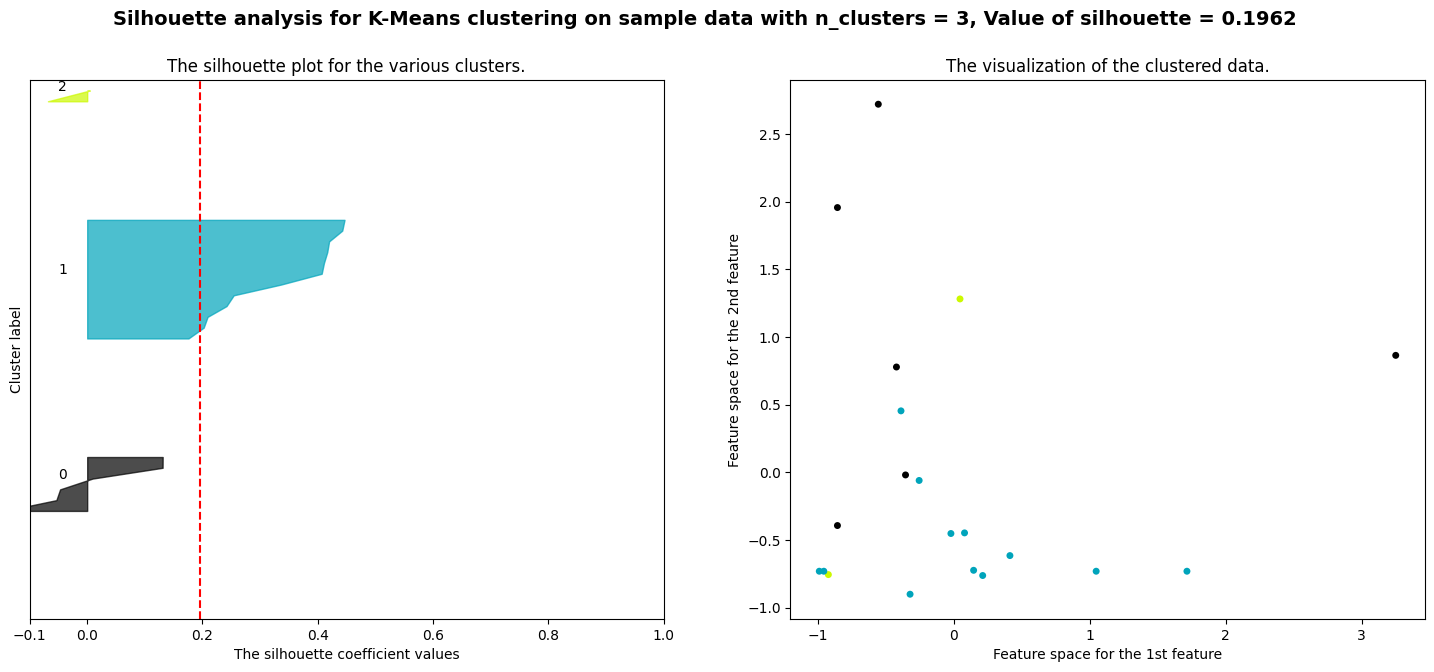

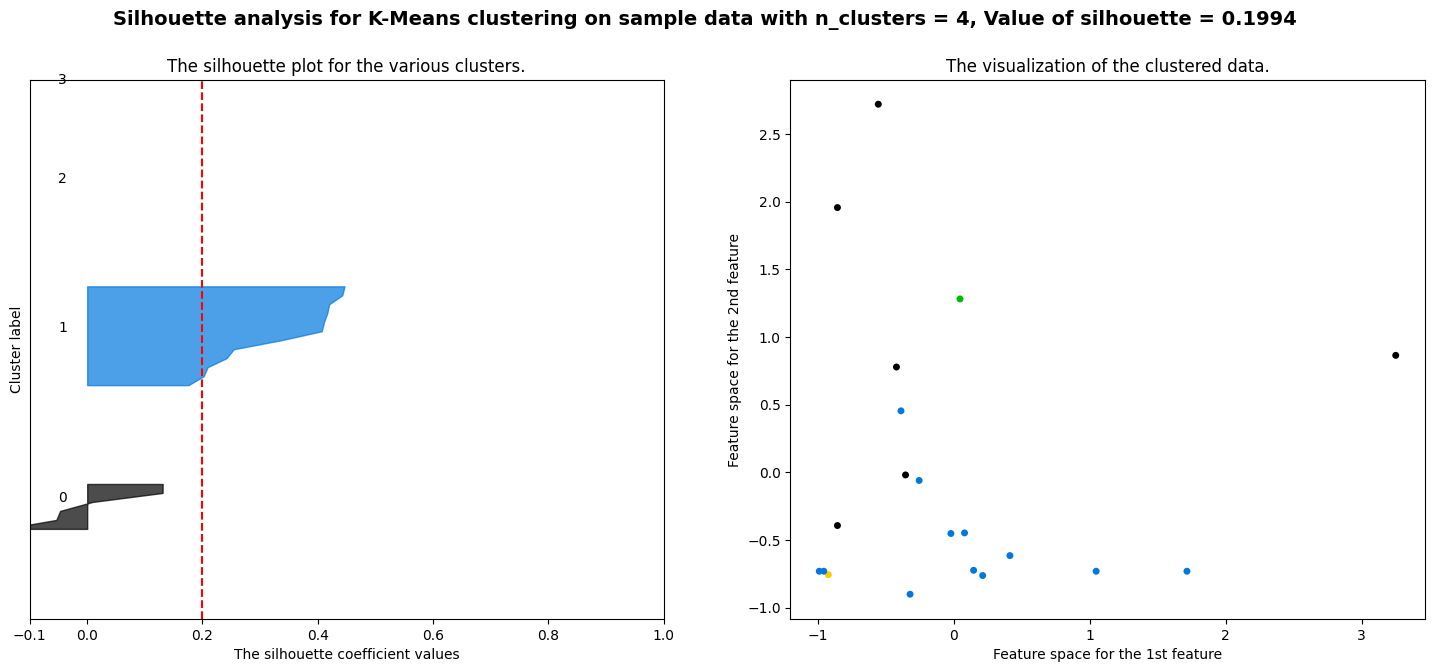

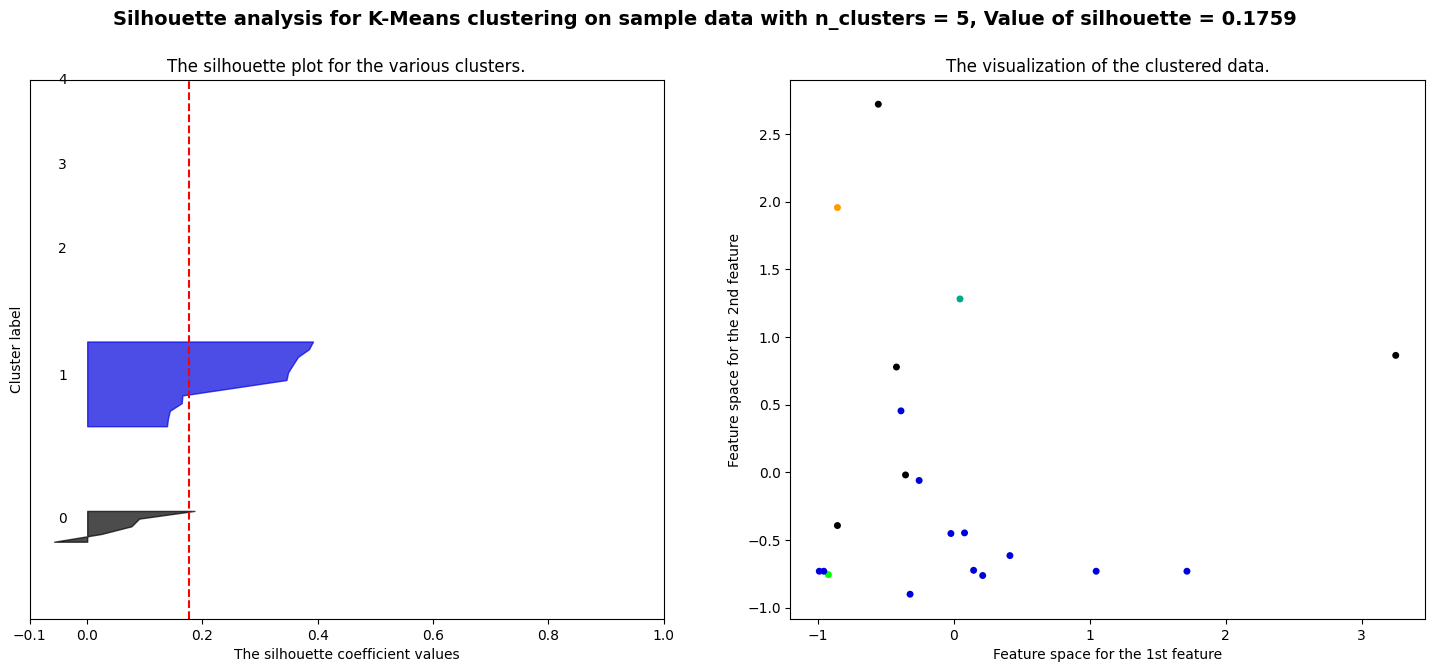

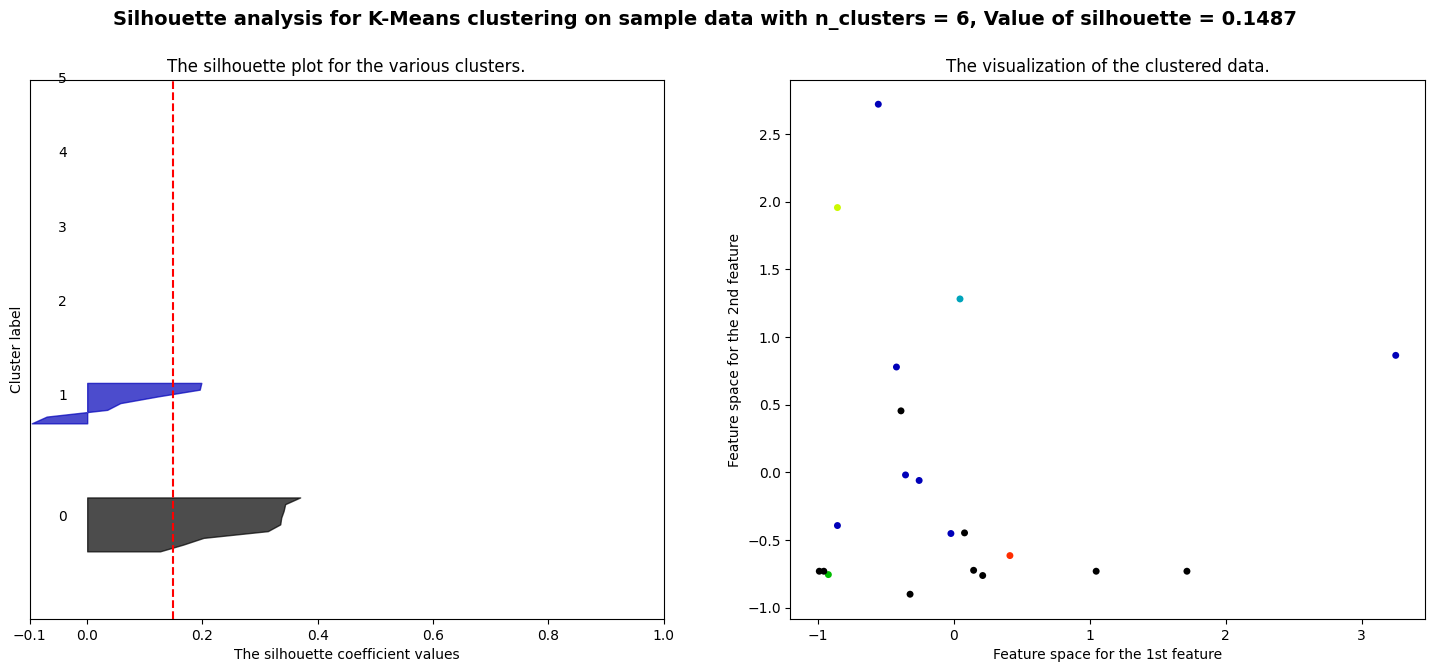

{'Number of\nClusters': dict_keys([2, 3, 4, 5, 6]),
 'Silhouette\nAnalysis': ['0.312**', '0.196', '0.199', '0.175', '0.148'],
 'Calinski\nHarabasz': ['5.829**', '5.544*', '5.514*', '5.722*', '5.721*'],
 'Davies\nBoulding': ['1.654', '1.509', '1.051', '0.906*', '0.824**']}

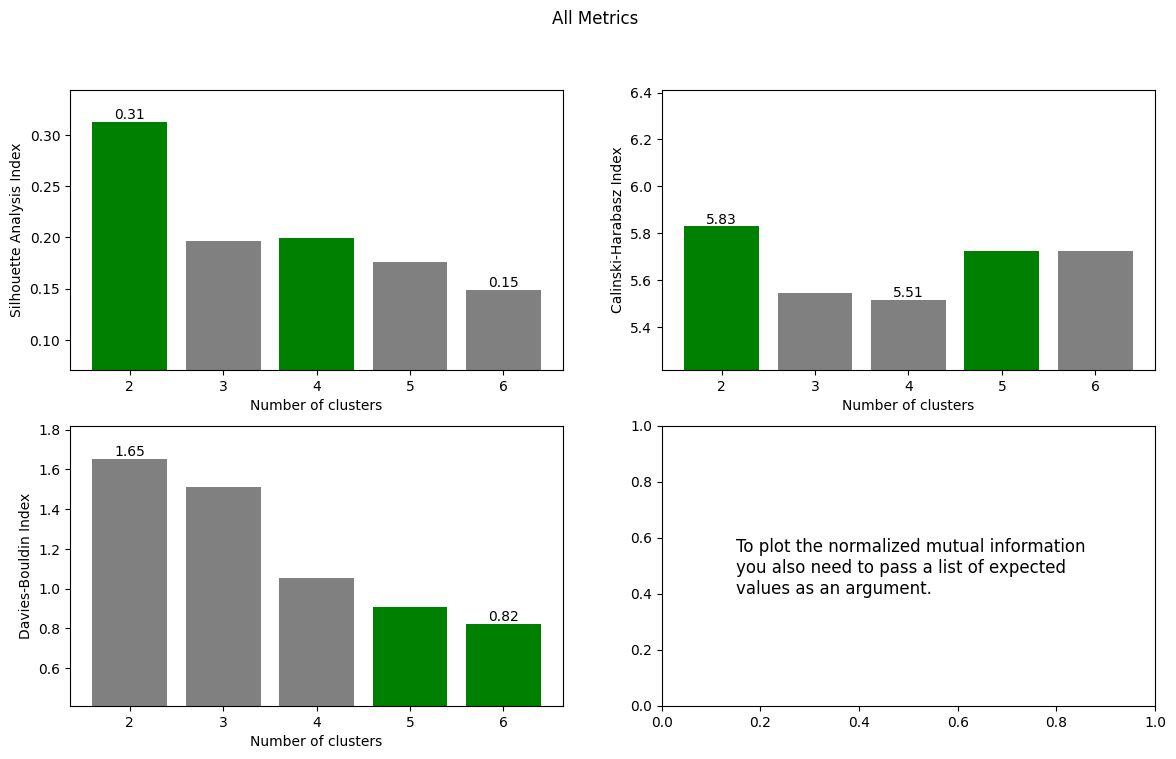

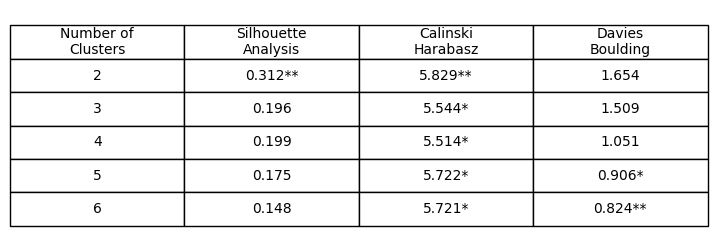

In [ ]:
mtr.print_metrics(clusters_list_outubro, df_outubro_values)

# Gráficos
Nessa etapa, foi impresso um mapa da região com pontos coloridos que representam os poços de coleta dos dados. As cores representam os rótulos resultantes do agrupamento feito pelo algoritmo K-Means.

Para cada período análisado, serão impressos os 5 mapas, cada mapa com um número de grupo.

## Mapas para o a coleta de Abril


In [ ]:
for k in range(2,7):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_abril[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple']  # Cores para cada rótulo
  for i in range(df_abril.shape[0]):
      cor = cores[clusters_list_abril[k-2, i]]
      folium.CircleMarker(location=coordenadas_abril[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_abril.iloc[i, 0], df_abril.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/kmeans_abril_com_coord_k_{k}.html")


## Mapas para o a coleta de Outubro


In [ ]:
for k in range(2,7):
  # Criar um mapa usando folium
  mapa = folium.Map(location=coordenadas_outubro[0], zoom_start=17)

  # Plotar os pontos no mapa com cores correspondentes aos rótulos
  cores = ['red', 'blue', 'green', 'orange', 'yellow', 'purple']  # Cores para cada rótulo
  for i in range(df_outubro.shape[0]):
      cor = cores[clusters_list_outubro[k-2, i]]
      folium.CircleMarker(location=coordenadas_outubro[i], color=cor, fill=True, fill_color=cor, radius=8, tooltip=(df_outubro.iloc[i, 0], df_outubro.iloc[i, 1])).add_to(mapa)

  # Exibir o mapa
  mapa.save(f"/content/drive/Shareddrives/datasci4water/IG/data/interim/maps/kmeans_outubro_com_coord_k_{k}.html")
